In [1]:
from __future__ import division, print_function
%matplotlib inline

In [2]:
cd ..

/Users/megret/Documents/Teaching/COMP6838_Computer_Vision/Lab/visionlab/lectures


# Color and exposure

In [3]:
import matplotlib.pyplot as plt
import numpy as np

## <span style="color:cornflowerblue">Exercise:</span>

Create three images; each should display a red, green, or blue channel of the original image.

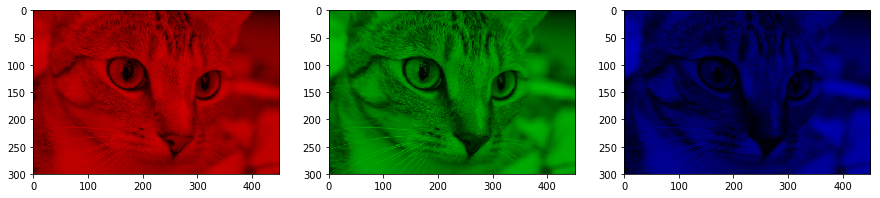

In [4]:
import skdemo
from skimage import data
color_image = data.chelsea()

red_image = np.zeros_like(color_image)
green_image = np.zeros_like(color_image)
blue_image = np.zeros_like(color_image)

red_image[:, :, 0] = color_image[:, :, 0]
green_image[:, :, 1] = color_image[:, :, 1]
blue_image[:, :, 2] = color_image[:, :, 2]

skdemo.imshow_all(red_image, green_image, blue_image)

Alternatively, we can "unpack" our RGB image into red, green, and blue channels using `np.rollaxis`

In [5]:
np.rollaxis(color_image, axis=-1).shape

(3, 300, 451)

The `axis` argument tells `rollaxis` which axis to... ahem... roll to the front.

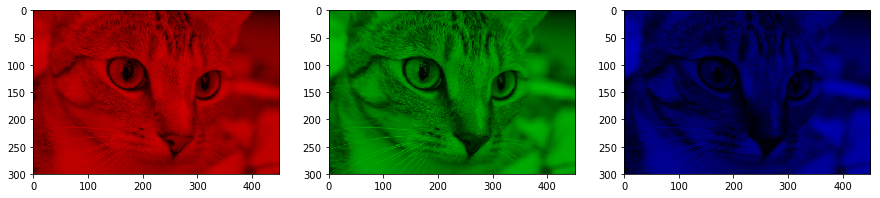

In [6]:
red_image = np.zeros_like(color_image)
green_image = np.zeros_like(color_image)
blue_image = np.zeros_like(color_image)

r, g, b = np.rollaxis(color_image, axis=-1)
red_image[:, :, 0] = r
green_image[:, :, 1] = g
blue_image[:, :, 2] = b

skdemo.imshow_all(red_image, green_image, blue_image)

## Histograms

## <span style="color:cornflowerblue">Question:</span>

The following attempt to plot as histogram does not work:

```python
plt.hist(color_image);
```

The code above raises the following error:

> ValueError: x must be 1D or 2D

As the error suggests, a 3D, color image will not work with a histogram

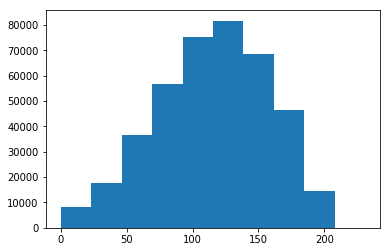

In [7]:

plt.hist(color_image.flatten());

These bins are really coarse, so lets use the `bins` argument to `plt.hist` to get a better result:

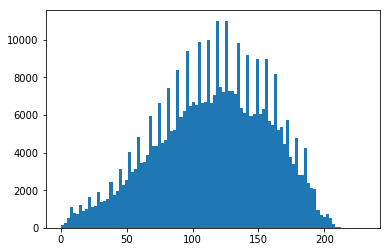

In [8]:
plt.hist(color_image.flatten(), bins=100);

Why does that look so strange? (Think about it before continuing.)

The pixel values are integers, and we're dividing up the data into 100 bins. If the number of integers isn't a divisor of the range of integers, then some bins will have more integers than others. Let's take a look at the number of unique bins:

In [9]:
np.ptp(color_image)

231

`np.ptp` gives the difference between the min and max values. If we used 115 bins, every bin would have approximately 2 integers, and we should get a good-looking histogram. If we use a bit fewer bins, then some bins will have 3 integers instead of 2; if go a bit higher, then some bins will have a bit fewer integers.

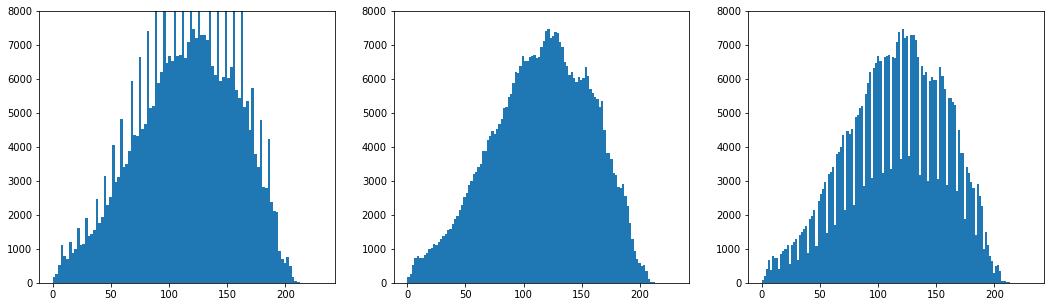

In [10]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

for ax, bins in zip(axes, (100, 115, 130)):
    ax.hist(color_image.flatten(), bins=bins);
    ax.set_ylim(ymax=8000)

## <span style="color:cornflowerblue">Exercise:</span>

Create a function to **plot a histogram for each color channel** in a single plot.

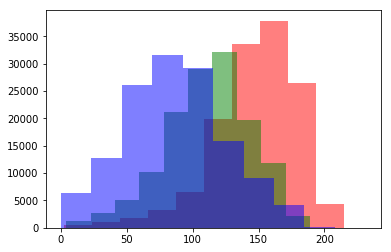

In [11]:
for color, channel in zip('rgb', np.rollaxis(color_image, axis=-1)):
    plt.hist(channel.flatten(), color=color, alpha=0.5)

Bonus: Instead of using `plt.hist`, use `plt.plot` or `plt.fill_between` in combination with `histogram` from `skimage.exposure`.

In [12]:
from skimage import exposure
exposure.histogram?

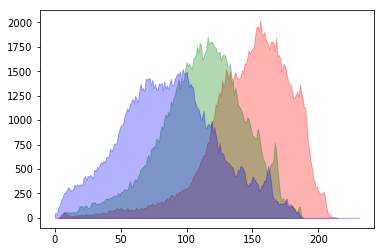

In [13]:
for color, channel in zip('rgb', np.rollaxis(color_image, axis=-1)):
    hist, bin_centers = exposure.histogram(channel)
    plt.fill_between(bin_centers, hist, color=color, alpha=0.3)

## Color spaces

## <span style="color:cornflowerblue">Exercise:</span>

### HSV colorspace

Other common colorspaces are: Hue-Saturation-Value (HSV)

/Users/megret/anaconda/envs/bnl/lib/python3.5/site-packages/skimage/util/dtype.py:47: UserWarning: The default of `clip_negative` in `skimage.util.dtype_limits` will change to `False` in version 0.15.
  warn('The default of `clip_negative` in `skimage.util.dtype_limits` '


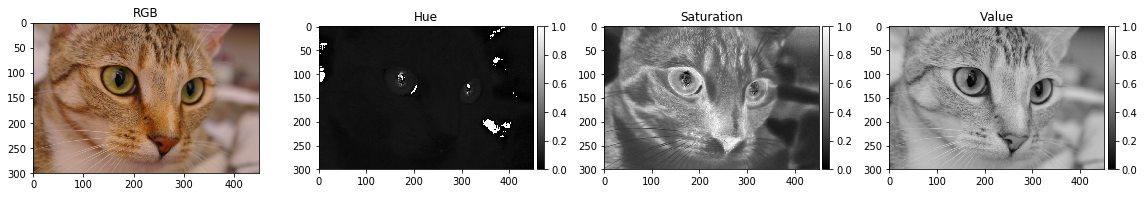

In [14]:
from skimage import color
hsv_image = color.rgb2hsv(color_image)

skdemo.imshow_all(color_image, hsv_image[..., 0], hsv_image[..., 1], hsv_image[..., 2],
                 titles=['RGB', 'Hue', 'Saturation', 'Value'], limits='dtype', size=4)

# Change colormap just for Hue, as values wrap around from 1.0 to 0.0
#plt.gcf().axes[1].get_images()[0].set_cmap('hsv')

# Show colorbars except for RGB
skdemo.colorbars(axes=plt.gcf().axes[1:4]);  plt.tight_layout()

### Chelsea eyes

Use the CIELAB color space to **isolate the eyes** in the `chelsea` image. Plot the L, a, b components to get a feel for what they do, and see the [wikipedia page](http://en.wikipedia.org/wiki/Lab_colorspace) for more info. Bonus: **Isolate the nose** too.

In [15]:
from skimage import color

lab_image = color.rgb2lab(color_image)

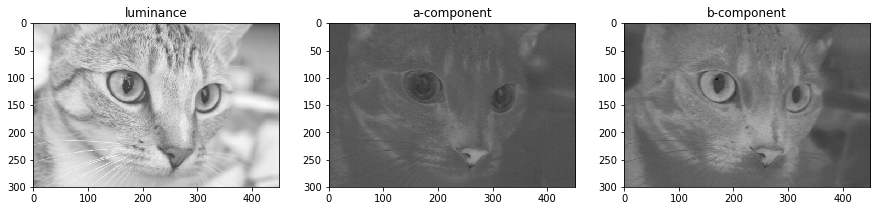

In [16]:
luminance, a, b = np.rollaxis(lab_image, axis=-1)
titles = ['luminance', 'a-component', 'b-component']
skdemo.imshow_all(luminance, a, b, titles=titles)

Notice the eyes are really dark in the middle image, i.e. the "A"-component of the LAB color space. We should use that for thresholding. We don't want to just guess values for thresholding; instead, let's look at a histogram:

In [17]:
#skdemo.imshow_with_histogram(lab_image);

I've cheated here and reused our RGB histogram for LAB space. The image is wrong because the image isn't RGB, but the histograms are still valid. Note that we're plotting in RGB order, so the "A" commponent here is green. Since the eyes are very dark in the "A" image above, we'd like to select the left tail of the green histogram---roughly at 0:

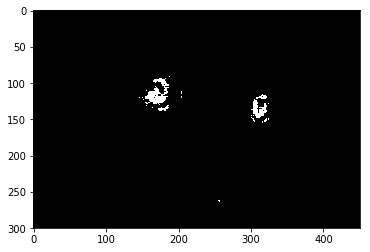

In [18]:
plt.imshow(a < 0)

To get the nose, notice that it's quite bright in the "A" component, so lets grab the right tail of the green histogram (> 30).

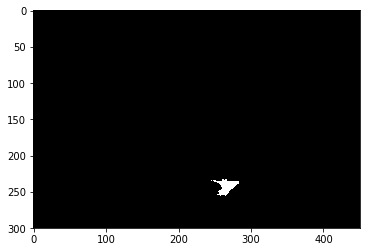

In [19]:
plt.imshow(a > 30)

Combining those two, plus an extra bit of thresholding to blacken the pupil, gives:

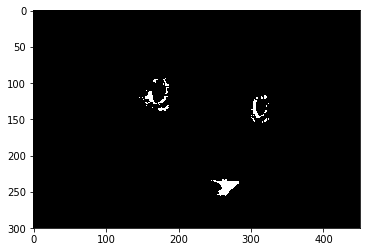

In [20]:
eyes = (a < 0) & (b > 5)
nose = a > 30
plt.imshow(eyes | nose)

Note that we want to select pixels that are either the nose or the eyes; you might be tempted to write `eyes & nose`, but that would only keep pixels that are both part of the eyes and the nose, which is an empty set.

# Image filtering

In [21]:
# Replicate image from demo
image = data.camera()
pixelated = image[::10, ::10]

In the image filtering section, our first attempt at applying a difference filter didn't produce good results

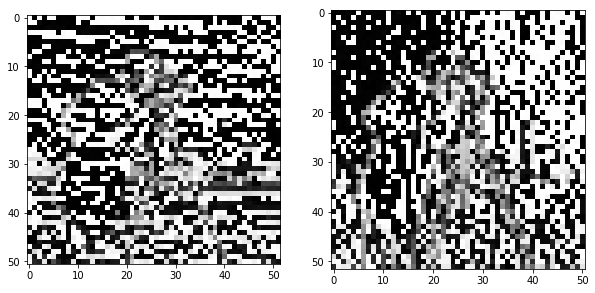

In [22]:
horizontal_edges = pixelated[1:, :] - pixelated[:-1, :]
vertical_edges = pixelated[:, 1:] - pixelated[:, :-1]
skdemo.imshow_all(horizontal_edges, vertical_edges)

The reason for the noise is that these images are unsigned, 8-bit integers:

In [23]:
print pixelated.dtype, horizontal_edges.dtype, vertical_edges.dtype

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-23-b711609506ce>, line 1)

If you subtract two values, and the result is negative, then that value wraps around (underflow); thus, -1 becomes 255. Similarly, values exceeding 255, will wrap around (overflow) so that 256 becomes -1.

To fix this, we'll convert to floating-point images:

In [ ]:
from skimage import img_as_float
pixelated_float = img_as_float(pixelated)
horizontal_edges = pixelated_float[1:, :] - pixelated_float[:-1, :]
vertical_edges = pixelated_float[:, 1:] - pixelated_float[:, :-1]
skdemo.imshow_all(horizontal_edges, vertical_edges)

## <span style="color:cornflowerblue">Exercise:</span>

Create a simple difference filter to **find the horizontal or vertical edges** of an image. Try to ensure that the filtering operation doesn't shift the edge position preferentially. (Don't use slicing to produce the difference image; use convolution.)

In [ ]:
def imshow_edges(image, horizontal_edge_kernel, vertical_edge_kernel):
    horizontal_edges = convolve(image, horizontal_edge_kernel)
    vertical_edges = convolve(image, vertical_edge_kernel)
    skdemo.imshow_all(horizontal_edges, vertical_edges)

We can emulate the simple differencing operation that we did earlier with the following edge kernels:

In [ ]:
from skimage import img_as_float
from scipy.ndimage import convolve

horizontal_edge_kernel = np.array([[1], [-1]])
vertical_edge_kernel = np.array([[1, -1]])

# As discussed earlier, use a floating-point image to prevent overflow
image = img_as_float(pixelated)
imshow_edges(image, horizontal_edge_kernel, vertical_edge_kernel)

But, as we said earlier, this tends to skew the edges toward one corner of the image. To preserve the position of edge points, we can create a kernel that's centered on each pixel:

In [ ]:
horizontal_edge_kernel = np.array([[1], [0], [-1]])
vertical_edge_kernel = np.array([[1, 0, -1]])

imshow_edges(image, horizontal_edge_kernel, vertical_edge_kernel)

We can verify that this doesn't skew the edges by looking at the bright square from earlier

In [ ]:
# Replicate image from demo
bright_square = np.zeros((7, 7), dtype=float)
bright_square[2:5, 2:5] = 1

image = bright_square
horizontal_edges = convolve(image, horizontal_edge_kernel)
vertical_edges = convolve(image, vertical_edge_kernel)
skdemo.imshow_all(horizontal_edges, vertical_edges)

## <span style="color:cornflowerblue">Exercise:</span>

Using a couple of the filters in the `filter` module, **find the direction of the maximum gradient** in an image.

**NOTE:** When developing this exercise, it was assumed that `vsobel` and `hsobel` from `skimage.filter` returned the response from the vertical-edge and horizontal-edge Sobel kernels, pictured in the links below:

* http://scikit-image.org/docs/dev/api/skimage.filter.html#vsobel
* http://scikit-image.org/docs/dev/api/skimage.filter.html#hsobel

As described in those docs, however, the **absolute value** of the response is returned. While this result is typically preferred, it's not in this case, since the sign of the response contributes to the gradient angle.

To get around this oversight, we'll copy the edge kernels from the documentation:

In [ ]:
from skimage import filter

# Kernel copied from `vsobel` docstring.
# Vertical edge-reponse is the *horizontal* gradient.
dx_kernel = np.array([
    [1,   0,  -1],
    [2,   0,  -2],
    [1,   0,  -1],
])
# Rotate array by 90 degrees to get y-gradient kernel
dy_kernel = np.rot90(dx_kernel)

In [ ]:
image_45 = np.tril(-np.ones([7, 7]))
image_135 = np.rot90(image_45)
skdemo.imshow_all(image_45, image_135)

In [ ]:
def angle_image(image):
    image = img_as_float(image)
    dy = convolve(image, dy_kernel)
    dx = convolve(image, dx_kernel)

    angle = np.arctan2(dy, dx)
    return np.degrees(angle)

In [ ]:
%precision 0
angle_image(image_45)

In [ ]:
angle_image(image_135)

# Feature detection

## <span style="color:cornflowerblue">Exercise:</span>

Use the response from the Hough transform to **detect the position and radius of each coin**.

First, let's replicate the data from the tutorial

In [ ]:
from skimage.transform import hough_circle

image = data.coins()[0:95, 180:370]
edges = filter.canny(image, sigma=3, low_threshold=10, high_threshold=60)
hough_radii = np.arange(15, 30, 2)
hough_response = hough_circle(edges, hough_radii)

In [ ]:
from skimage.feature import peak_local_max

centers = []
likelihood = []

for h in hough_response:
    peaks = peak_local_max(h)
    centers.extend(peaks)
    likelihood.extend(h[peaks[:, 0], peaks[:, 1]])

for i in np.argsort(likelihood)[-3:]:
    row, column = centers[i]
    plt.plot(column, row, 'ro')
    plt.imshow(image)

In [ ]:
coin_centers

In [ ]:
a = np.arange(10)
a[np.arange(3)]

In [ ]:
centers

In [ ]:
from skimage.feature import peak_local_max

radii = []
centers = []
likelihood = []
for h, r in zip(hough_response, hough_radii):
    peaks = peak_local_max(h)
    radii.extend([r] * len(peaks))
    centers.extend(peaks)
    likelihood.extend(h[peaks[:, 0], peaks[:, 1]])

In [ ]:
from skimage.draw import circle_perimeter
from skimage.color import gray2rgb

drawn_image = gray2rgb(image)
plt.imshow(drawn_image)
for i in np.argsort(likelihood)[-3:]:
    row, column = centers[i]
    rr, cc = circle_perimeter(row, column, radii[i])
    drawn_image[rr, cc, 1:] = 0
    plt.plot(column, row, 'ro')

In [ ]:
circle_perimeter?